K-Means performance evaluation

CIFAR-10

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist


def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar10_data(data_dir, negatives=False):

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []


    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))

    cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.uint8)
    #cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)


    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    #cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.uint8)

    #cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_labels, cifar_test_data, cifar_test_labels

def flatten_data(x):
    samples = x.shape[0]
    flattened_shape = 1
    for dim in x.shape[1:]:
        flattened_shape *= dim
    return x.reshape(samples, flattened_shape)

def generate_kmeans_model(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    transformed = kmeans.fit_predict(X)
    return kmeans, transformed

def pca_encode(pca_model, X):
    return pca_model.transform(X)

def pca_decode(pca_model, X):
    return pca_model.inverse_transform(X)

def clusters_to_index(cluster_labels):
    dict = {}
    for i in range(len(cluster_labels)):
        if cluster_labels[i] in dict:
            dict[cluster_labels[i]].append(i)
        else:
            dict[cluster_labels[i]] = [i]
    return dict

# reconstruct data from N*3072 to N*32*32*3
def construct_image_from_flattern(x, colored = True):
    samples = x.shape[0]
    if colored:
      return x.reshape(samples, 32, 32, 3).astype("uint8")
    else:
      return x.reshape(samples, 32, 32).astype("uint8")

#visualize image data, displayed on row*col grid, x's 1st-dim >= (row*col)
def visualize_data(x, n, ncol, plt_size):
    nrow = n // ncol + 1
    #fig, axes1 = plt.subplots(nrows=nrow, ncols=ncol)
    plt.figure(figsize=(plt_size, plt_size))
    for i in range(n):
        #if i == n: break
        plt.subplot(nrow, ncol, i+1)
        plt.axis("off")
        plt.imshow(x[i])
        #axes1[k].set_axis_off()
        #axes1[k].imshow(x[k])
    plt.tight_layout()
    plt.show()
    return
    
# visualizing kmeans cluster centers
def visualize_kmeans_centre(kmeans_model, pca_model, n, ncol, colored = True):
    cluster_centers = kmeans_model.cluster_centers_
    cluster_centers_decoded = pca_decode(pca_model, cluster_centers)
    cluster_centers_decoded_image = construct_image_from_flattern(cluster_centers_decoded, colored)
    visualize_data(cluster_centers_decoded_image, n, ncol, 15)

def elbow_method(data, n_range, method='inertia'):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    for k in n_range:
        # Building and fitting the model
        km = KMeans(n_clusters=k).fit(data)
        km.fit(data)
    
        distort = sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]
        distortions.append(distort)
        inertias.append(km.inertia_)
    
        mapping1[k] = sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]
        mapping2[k] = km.inertia_

    if method == 'inertia':
        plt.plot(n_range, inertias, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.show()
    elif method == 'distortion':
        plt.plot(n_range, distortions, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method using Distortion')
        plt.show()
    else:
        raise ValueError("Method not supported")


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    #estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    kmeans_model = kmeans.fit(data)
    fit_time = time() - t0
    results = [name, fit_time, kmeans_model.inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.normalized_mutual_info_score,
    ]
    results += [m(labels, kmeans_model.labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            kmeans_model.labels_,
            metric="euclidean",
            #sample_size=300,
        ),
        metrics.calinski_harabasz_score(data, kmeans_model.labels_),
        metrics.davies_bouldin_score(data, kmeans_model.labels_)
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

    return kmeans_model

# def extract_feature(data):
#     #Manual Extraction
#     encoded = np.empty((data.shape[0], 3))
#     for i in range(data.shape[0]):
#         image = data[i]
        
#         r, g, b = image[..., 0], image[..., 1], image[..., 2]
#         r_mean = np.mean(r)
#         g_mean = np.mean(g)
#         b_mean = np.mean(b)
#         encoded[i] = np.array([r_mean, g_mean, b_mean])
#     return encoded

In [3]:
cifar_10_dir = 'cifar-10-batches-py'
# load data
train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar_10_dir)
print(train_data.shape)
# flatten data
train_vec = flatten_data(train_data)
test_vec = flatten_data(test_data)
print(train_vec.shape)

(50000, 32, 32, 3)
(50000, 3072)


(10000, 50)


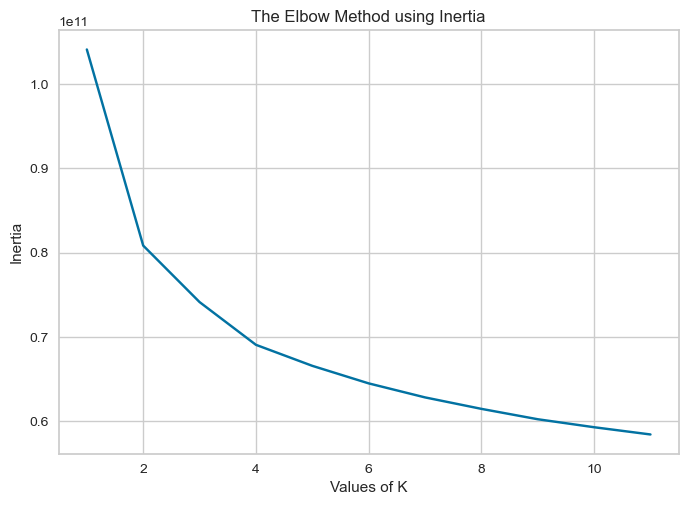

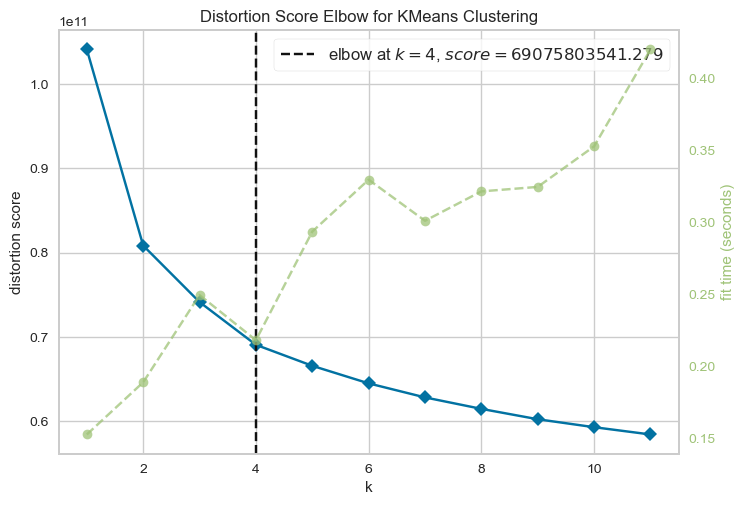

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
from yellowbrick.cluster import KElbowVisualizer

feature_vector_size = 50

# #PCA
pca_model = PCA(n_components=feature_vector_size).fit(test_vec)
encoded = pca_model.transform(test_vec)
print(encoded.shape)

# test for optimal k using elbow plot
# elbow method 
elbow_method(encoded, range(1,12), method='inertia')
# elbow method package
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(encoded)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [13]:
# test performance with different number of cluster / PCA feature vector size
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

print("number of cluster: ", n_clusters)
print(100 * "_")
print("init\t\ttime\tinertia\t\thomo\tcompl\tv-meas\tARI\tNMI\tsilhouette\tcalinski\tdavies")

# test with different vector size
feature_vector_size = 3
encoded = PCA(n_components=feature_vector_size).fit_transform(test_vec)
kmeans_model1 = bench_k_means(kmeans, name="k-means+PCA"+str(feature_vector_size), data=encoded, labels=test_labels)

feature_vector_size = 10
encoded = PCA(n_components=feature_vector_size).fit_transform(test_vec)
kmeans_model2 = bench_k_means(kmeans, name="k-means+PCA"+str(feature_vector_size), data=encoded, labels=test_labels)

feature_vector_size = 50
encoded = PCA(n_components=feature_vector_size).fit_transform(test_vec)
kmeans_model3 = bench_k_means(kmeans, name="k-means+PCA"+str(feature_vector_size), data=encoded, labels=test_labels)

# test with different cluster size
# n_clusters = 3
# kmeans = KMeans(n_clusters=n_clusters, random_state=0)
# encoded = PCA(n_components=feature_vector_size).fit_transform(test_vec)
# kmeans_model1 = bench_k_means(kmeans, name="k-means+PCA"+str(feature_vector_size), data=encoded, labels=test_labels)

# n_clusters = 5
# kmeans = KMeans(n_clusters=n_clusters, random_state=0)
# encoded = PCA(n_components=feature_vector_size).fit_transform(test_vec)
# kmeans_model2 = bench_k_means(kmeans, name="k-means+PCA"+str(feature_vector_size), data=encoded, labels=test_labels)

# n_clusters = 10
# kmeans = KMeans(n_clusters=n_clusters, random_state=0)
# encoded = PCA(n_components=feature_vector_size).fit_transform(test_vec)
# kmeans_model3 = bench_k_means(kmeans, name="k-means+PCA"+str(feature_vector_size), data=encoded, labels=test_labels)

print(100 * "_")

number of cluster:  10
____________________________________________________________________________________________________
init		time	inertia		homo	compl	v-meas	RI	AMI	silhouette	calinski	davies
k-means+PCA3	0.261s	13549848447	0.075	0.076	0.076	0.822	0.074	0.229		3635.879	1.116
k-means+PCA10	0.302s	35973656162	0.084	0.085	0.084	0.823	0.083	0.107		1380.010	1.844
k-means+PCA50	0.319s	59301844787	0.085	0.086	0.086	0.823	0.084	0.066		838.292	2.420
____________________________________________________________________________________________________


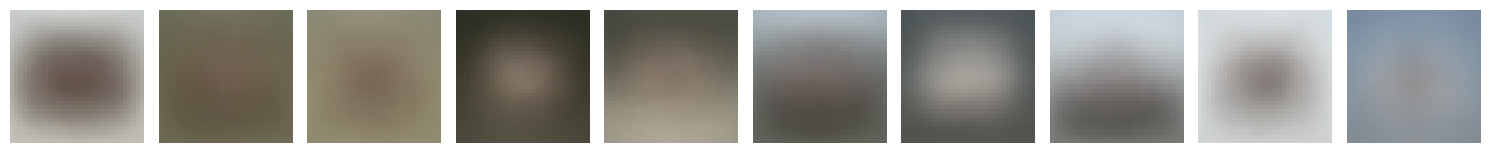

0


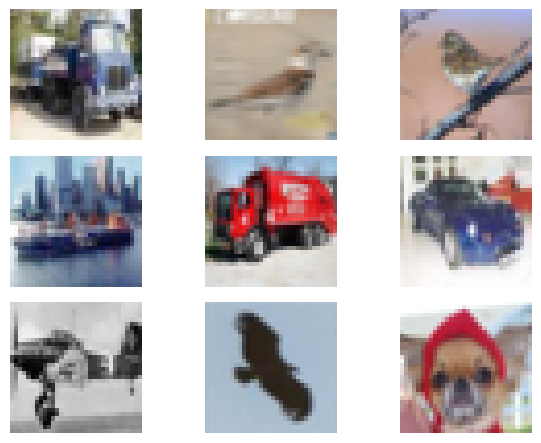

1


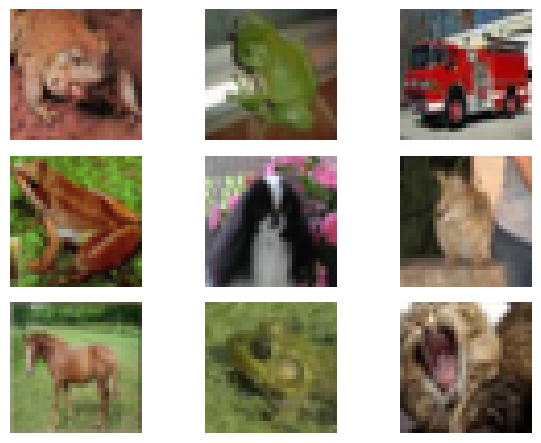

2


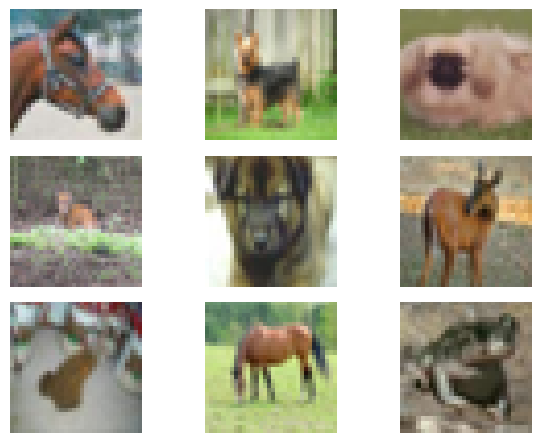

3


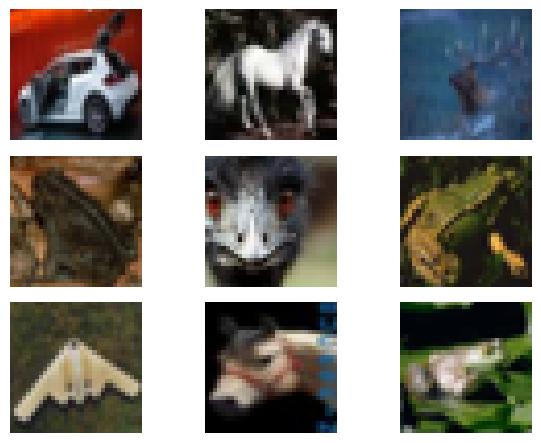

4


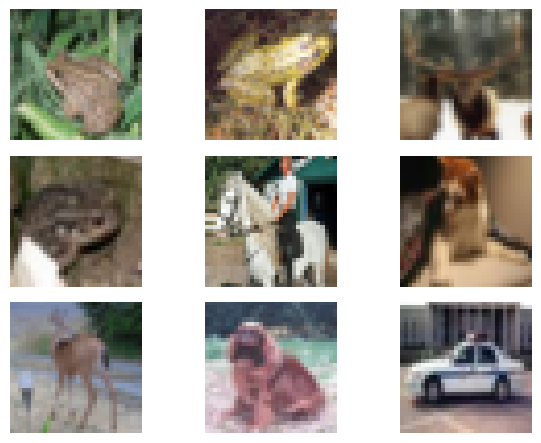

5


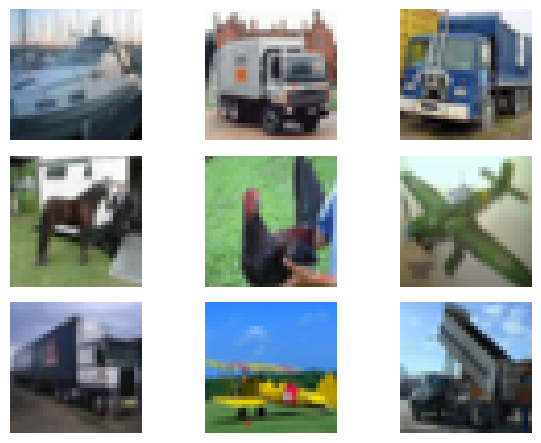

6


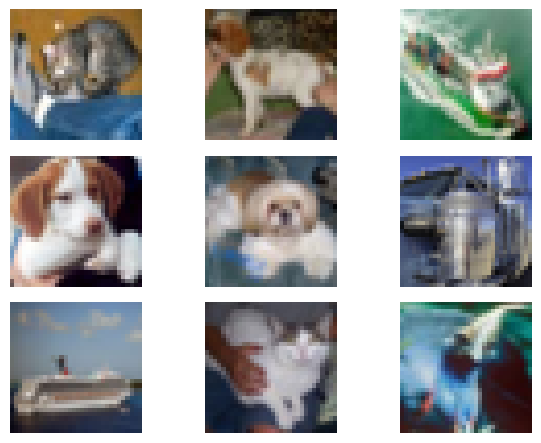

7


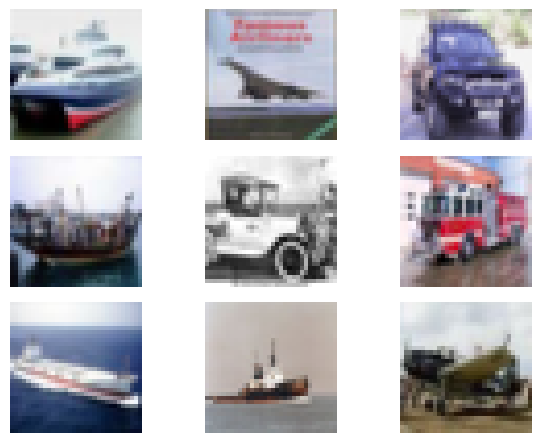

8


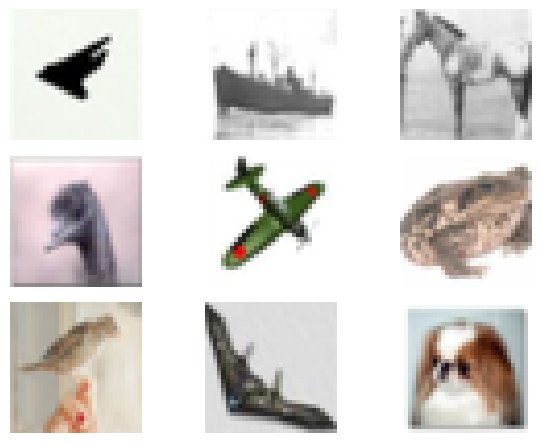

9


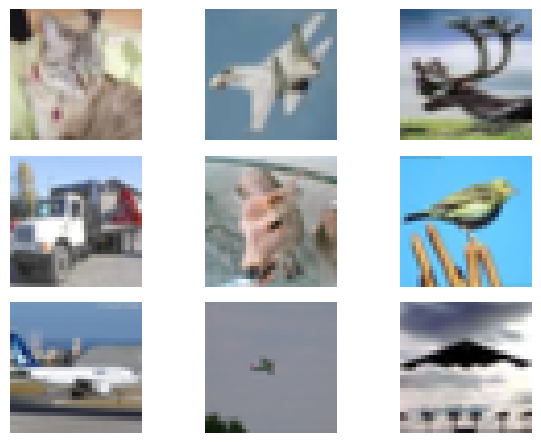

In [14]:
visualize_kmeans_centre(kmeans_model3, pca_model, n=n_clusters, ncol=n_clusters)

# Vidualize image clusters
cluster_index_dict = clusters_to_index(kmeans_model3.labels_)
for cluster in sorted(list(cluster_index_dict.keys())):
    print(cluster)
    image_index = cluster_index_dict[cluster]
    images = test_data[image_index]
    visualize_data(images, n=9, ncol=3, plt_size=6)

(1000, 2)
11176.658063383722
7485.513516199147


c:\Users\junbo\anaconda3\envs\csc2515\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


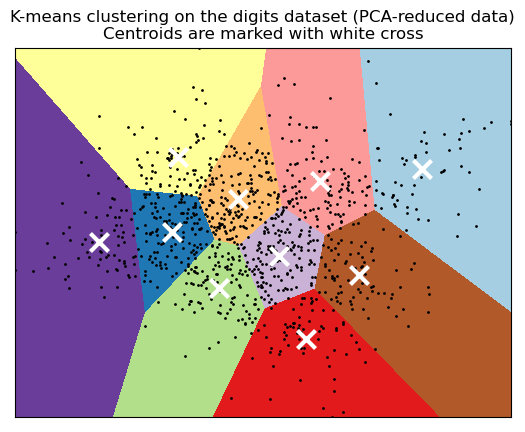

In [87]:
# visualizing clusters
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(test_vec)[0:1000]
print(reduced_data.shape)
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 2  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
print(x_max - x_min)
print(y_max - y_min)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on cifar10 dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [15]:
from sklearn import metrics
print(metrics.rand_score(labels, test_labels))
print(metrics.adjusted_rand_score(labels, test_labels))
print(metrics.adjusted_mutual_info_score(labels, test_labels))
print(metrics.normalized_mutual_info_score(labels, test_labels))
# metrics.homogeneity_score(labels_true, labels_pred)
# metrics.completeness_score(labels_true, labels_pred)
# metrics.v_measure_score(labels_true, labels_pred)
print(metrics.homogeneity_completeness_v_measure(labels, test_labels))
print(metrics.silhouette_score(encoded, labels, metric='euclidean'))
#print(metrics.adjusted_rand_score([0,0,1,1,2,2], [4,4,5,5,6,6]))

NameError: name 'labels' is not defined